In [7]:
import os
import subprocess
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (12.0, 6.0)

## Unzip the transactions Data!

In [16]:
filename = 'raw_committee_transactions.csv'
filepath = os.path.join('..', 'data', filename)
kwargs = {'stdin': subprocess.PIPE, 'stdout': subprocess.PIPE, 'stderr': subprocess.STDOUT, 'close_fds': True}
if os.path.isfile(filepath + '.tar.gz'):
    cmd = ['tar', '-xzf', filepath + '.tar.gz']
else:
    # TODO: use -c to retain the gz file: `gunzip -c filepath.gz >filepath.csv`
    cmd = ['gunzip', 'filepath + '.gz']
process = subprocess.Popen(cmd, **kwargs)
output = process.stdout.read()
retval = process.wait()
if retval:
    print(output)
    print(retval)


0


## Need to be memory efficient by specifying '`dtype`'s
And need to limit it to 1M rows for 8GB laptop

In [58]:
trans = pd.read_csv(filepath, nrows=10000)
dtype_orig = dict([(col, df[col].dtype) for col in df.columns])
dtype = dict(dtype_orig)
object_keywords = ('note', 'txt', 'text', 'title', 'percent', 'rate', 'comment', 'desc', 'name', 'city', 'state', 'addr', 'line', 'code')
for i, col in enumerate(trans.columns):
    if 'date' in col or 'time' in col:
        dtype[col] = pd.Timestamp
    elif any([k in col for k in object_keywords]):
        dtype[col] = pd.np.object
    elif 'amount' in col:
        dtype[col] = pd.np.float64
    print(i, col, dtype_orig[col], dtype[col])
# "_id" is a string in some cases  ;)
dtype['contributor_payee_committee_id'] = pd.np.object
trans = pd.read_csv(filepath, dtype=dtype, nrows=1000000)

(0, 'tran_id', dtype('int64'), dtype('int64'))
(1, 'original_id', dtype('int64'), dtype('int64'))
(2, 'tran_date', dtype('O'), <class 'pandas.tslib.Timestamp'>)
(3, 'tran_status', dtype('O'), dtype('O'))
(4, 'filer', dtype('O'), dtype('O'))
(5, 'contributor_payee', dtype('O'), dtype('O'))
(6, 'sub_type', dtype('O'), dtype('O'))
(7, 'amount', dtype('float64'), <type 'numpy.float64'>)
(8, 'aggregate_amount', dtype('int64'), <type 'numpy.float64'>)
(9, 'contributor_payee_committee_id', dtype('float64'), dtype('float64'))
(10, 'filer_id', dtype('int64'), dtype('int64'))
(11, 'attest_by_name', dtype('O'), <type 'object'>)
(12, 'attest_date', dtype('O'), <class 'pandas.tslib.Timestamp'>)
(13, 'review_by_name', dtype('O'), <type 'object'>)
(14, 'review_date', dtype('O'), <class 'pandas.tslib.Timestamp'>)
(15, 'due_date', dtype('O'), <class 'pandas.tslib.Timestamp'>)
(16, 'occptn_ltr_date', dtype('float64'), <class 'pandas.tslib.Timestamp'>)
(17, 'pymt_sched_txt', dtype('float64'), <type 'obje

In [52]:
len(trans)
trans.describe()

,tran_id,original_id,amount,filer_id,check_nbr,zip,zip_plus_four
count,977337.00000,977337.000000,977337.000000,977337.000000,1.855590e+05,699206.000000,21794.000000
mean,1123370.30258,1122072.520231,1053.874716,7043.355388,5.687585e+06,94101.176712,4276.766358
std,554181.86289,554621.433813,13955.958487,6106.562246,7.675640e+08,14429.060711,3060.712691
min,41.00000,41.000000,-43771.050000,3.000000,0.000000e+00,0.000000,-159.000000
25%,711115.00000,709522.000000,30.000000,682.000000,1.056000e+03,97086.000000,1672.000000
50%,1149574.00000,1148785.000000,116.770000,4572.000000,1.481000e+03,97223.000000,3726.000000
75%,1585532.00000,1584488.000000,494.500000,13926.000000,2.745500e+03,97401.000000,6989.000000
max,2049796.00000,2049796.000000,4460000.000000,17462.000000,2.942193e+11,99999.000000,9998.000000


## Hack '`describe`' to find the numeric columns

In [74]:
description = trans.describe()
# going to plot these later so need a few
trans = trans.set_index('tran_date') 
samples = trans[description.columns].sample(100000)
samples[:10]

,tran_id,original_id,amount,aggregate_amount,filer_id,check_nbr,zip,zip_plus_four
tran_date,,,,,,,,
2012-10-10,1371005,1371005,19.48,133.38,4572,NaN,97215,NaN
2014-01-08,1644041,1644041,53.18,0.00,5885,NaN,NaN,NaN
2012-03-20,1197738,1197738,50.00,0.00,15224,NaN,NaN,NaN
2011-12-28,1153227,1153227,106.45,106.45,15101,NaN,97031,NaN
2014-04-18,1705051,1705051,88.53,267.49,16719,1007,97222,NaN
2012-02-10,1170431,1170431,500.00,500.00,11527,NaN,97219,NaN
2013-12-06,1602705,1602705,18.32,201.42,4572,NaN,97140,NaN
2008-08-12,370699,370699,150.00,150.00,12654,NaN,97470,NaN
2012-04-19,1226650,1226650,10.31,0.00,135,NaN,NaN,NaN


## Surge in Donations During Elections (Halloween)

**PACs don't have to report until 1 month after they receive a donation... **  
**so big cozy donors know to wait until Oct to "donate"**

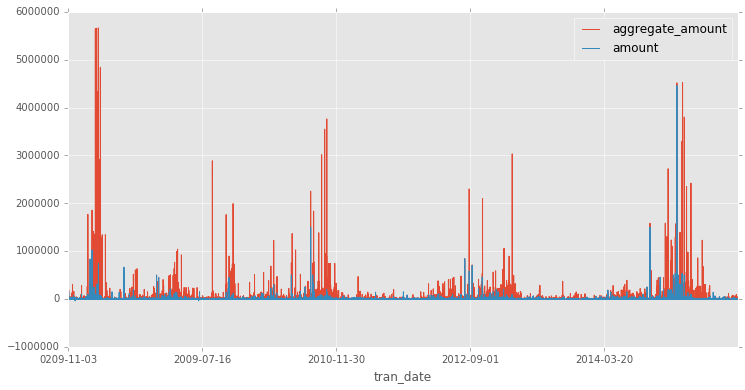

In [75]:
samples = samples.sort_index()
samples.describe()
samples[['aggregate_amount', 'amount']].plot()